In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import MobileNetV2
from tqdm.notebook import tqdm
import warnings
import datetime
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
from mlxtend.plotting import plot_confusion_matrix

# Ignore warning messages
warnings.filterwarnings("ignore")

# Display plots inline in Jupyter Notebook
%matplotlib inline

In [2]:
# Set the path to the training and testing directories
TRAIN_PATH = 'C:/Users/tusha/OneDrive/Desktop/AlmaBetter/Image Classification/seg_train'
TEST_PATH = 'C:/Users/tusha/OneDrive/Desktop/AlmaBetter/Image Classification/seg_test'

# Define the class names for the image categories
CLASS_NAMES = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

# Define the shape of the input images
IMG_SHAPE = (224, 224)

In [3]:
# Load training data using image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,                  # Path to the training dataset directory
    batch_size=32,               # Number of samples per batch
    image_size=IMG_SHAPE,        # Desired image size
    shuffle=True,                # Shuffle the data
    label_mode="categorical",    # Use categorical labels
    seed=42                      # Seed for reproducibility
)

# Load test data using image_dataset_from_directory
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,                   # Path to the test dataset directory
    batch_size=32,               # Number of samples per batch
    image_size=IMG_SHAPE,        # Desired image size
    shuffle=False,               # Do not shuffle the data for evaluation
    label_mode="categorical",    # Use categorical labels
    seed=42                      # Seed for reproducibility
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [4]:
samples = []  # Initialize an empty list to store samples
x = 0  # Initialize a counter

# Iterate through each element in the unbatched train_data
for i in tqdm(train_data.unbatch()):
    if (x == 10):  # Stop the loop after 10 samples
        break
    
    # Append the current sample (i[0]) and its label (i[1]) to the samples list
    samples.append([i[0], i[1]])
    
    x += 1  # Increment the counter

0it [00:00, ?it/s]

In [5]:
images = []  # Initialize an empty list to store the images
labels = []  # Initialize an empty list to store the labels

# Iterate over the samples
for i in samples:
    images.append(i[0])  # Append the image (i.e., input data) to the images list
    labels.append(CLASS_NAMES[tf.argmax(i[1])])  # Append the label (i.e., target class) to the labels list


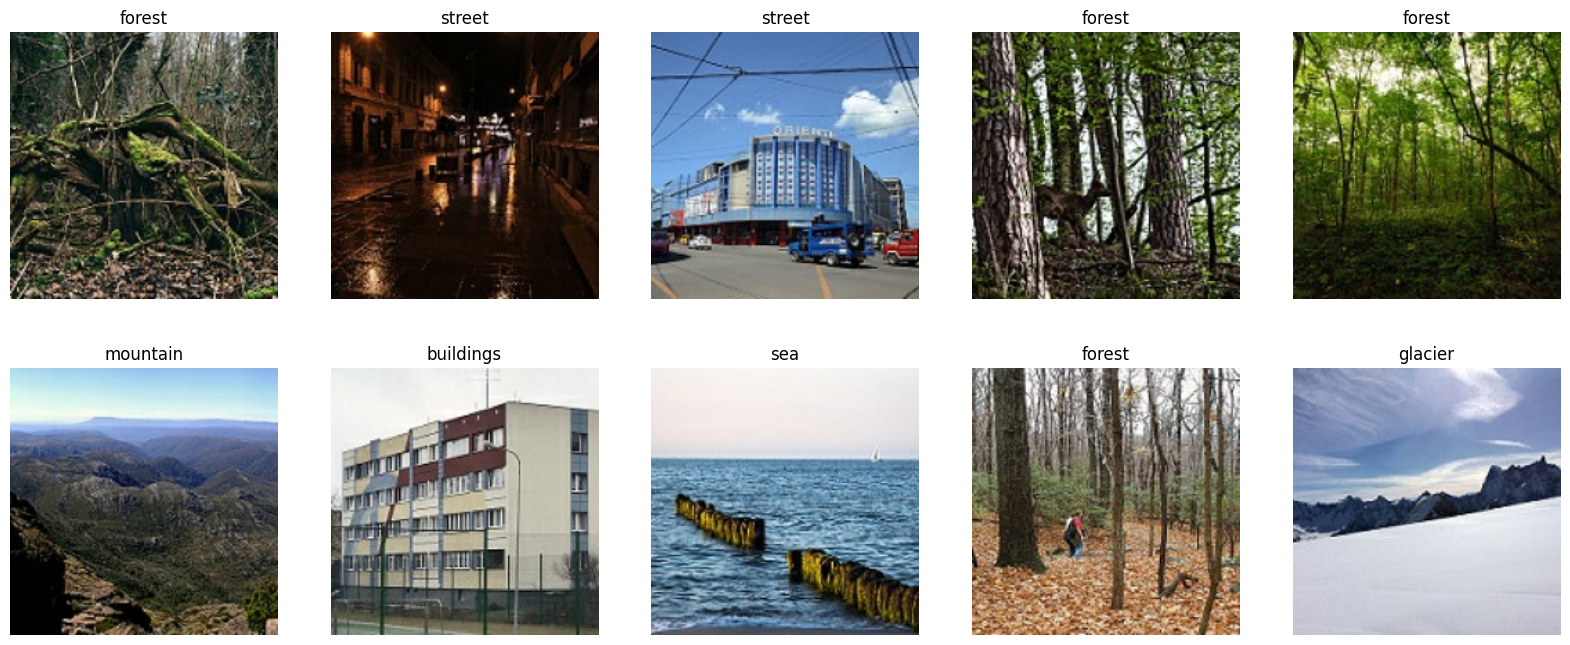

In [6]:
# Create a new figure with a specified size
fig = plt.figure(figsize=(20, 8))

# Define the number of rows and columns for the subplots
rows = 2
cols = 5

# Counter to keep track of the current subplot position
x = 1

# Iterate over each image and its corresponding label
for image, label in zip(images, labels):
    # Add a subplot to the figure at the current position
    fig.add_subplot(rows, cols, x)
    
    # Display the image, normalizing the pixel values to [0, 1]
    plt.imshow(image/255.)
    
    # Turn off axis labels
    plt.axis("off")
    
    # Check if label is not an empty string
    if label:
        # Set the title of the subplot to the corresponding label
        plt.title(label)
    
    # Increment the subplot counter
    x += 1


In [7]:
# Define a data augmentation block using tf.keras.models.Sequential
data_augmentation_block = tf.keras.models.Sequential([
    # Apply horizontal random flipping to the input images
    preprocessing.RandomFlip("horizontal"),
    
    # Apply random rotation to the input images by a factor of 0.2 (20%)
    preprocessing.RandomRotation(0.2),
    
    # Apply random height adjustment to the input images by a factor of 0.2 (20%)
    preprocessing.RandomHeight(0.2),
    
    # Apply random width adjustment to the input images by a factor of 0.2 (20%)
    preprocessing.RandomWidth(0.2),
    
    # Apply random zooming to the input images by a factor of 0.2 (20%)
    preprocessing.RandomZoom(0.2),
], name="data_augmentation")

In [8]:
def create_tensorboard_callback(dir_name, experiment_name):
    # Create the log directory path based on the provided directory name, experiment name, and current timestamp
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create a TensorBoard callback with the log directory
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    # Print the path where TensorBoard log files will be saved
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    # Return the TensorBoard callback
    return tensorboard_callback

In [9]:
# Directory name for the tensorboard logs
dir_name = "model_logs"

# Name of the experiment for the tensorboard logs
experiment_name = "EfficientNetB4 feature extraction"

# Create a tensorboard callback
tensorboarder = create_tensorboard_callback(dir_name, experiment_name)

Saving TensorBoard log files to: model_logs/EfficientNetB4 feature extraction/20230717-130728


In [10]:
# Define the path to save the checkpoints
checkpoint_path = "checkpoints/model.ckpt"

# Create a callback to save the model's weights during training
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                  monitor="val_accuracy",
                                                  save_best_only=False,
                                                  save_weights_only=True)

In [11]:
# Define the EarlyStopping callback
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",   # Monitor the validation accuracy for improvement
    patience=3,               # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore the weights from the epoch with the best performance
)

In [12]:
# Load the EfficientNetB4 model without the top (classification) layers
base = tf.keras.applications.EfficientNetB4(include_top=False)

# Set the base model as non-trainable
base.trainable = False

In [13]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation_block(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax", name="output_layer")(x)
model = tf.keras.models.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [14]:
# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 6)                 10758     
                                                                 
Total params: 17,684,581
Trainable params: 10,758
Non-trainab

In [15]:
history = model.fit(train_data, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_data), 
                    callbacks=[tensorboarder, checkpointer, earlystopper],
                    validation_steps=int(0.15*len(test_data)), 
                    use_multiprocessing=True)

Epoch 1/50
439/439 [==============================] - 113s 223ms/step - loss: 0.4446 - accuracy: 0.8479 - val_loss: 0.2750 - val_accuracy: 0.9107
Epoch 2/50
439/439 [==============================] - 95s 217ms/step - loss: 0.3105 - accuracy: 0.8891 - val_loss: 0.2500 - val_accuracy: 0.9129
Epoch 3/50
439/439 [==============================] - 95s 216ms/step - loss: 0.2865 - accuracy: 0.8958 - val_loss: 0.2679 - val_accuracy: 0.9085
Epoch 4/50
439/439 [==============================] - 94s 214ms/step - loss: 0.2767 - accuracy: 0.9007 - val_loss: 0.2413 - val_accuracy: 0.9174
Epoch 5/50
439/439 [==============================] - 95s 216ms/step - loss: 0.2688 - accuracy: 0.9028 - val_loss: 0.3045 - val_accuracy: 0.8929
Epoch 6/50
439/439 [==============================] - 95s 217ms/step - loss: 0.2645 - accuracy: 0.9045 - val_loss: 0.2015 - val_accuracy: 0.9375
Epoch 7/50
439/439 [==============================] - 95s 216ms/step - loss: 0.2516 - accuracy: 0.9097 - val_loss: 0.2232 - val_a

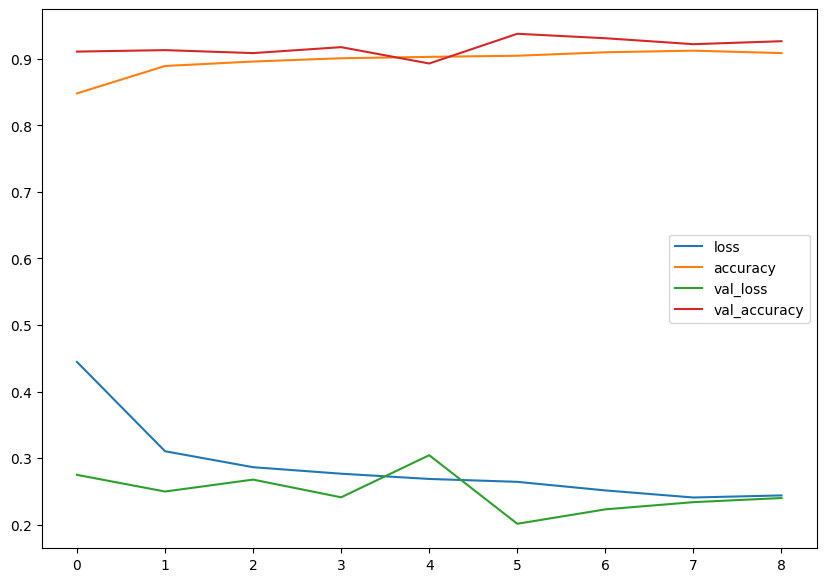

In [16]:
# Create a DataFrame from the history object and plot it
pd.DataFrame(history.history).plot(figsize=(10, 7))

# Display the plot
plt.show()

In [17]:
# Evaluate the model on the test data
evaluation_results = model.evaluate(test_data)

94/94 [==============================] - 10s 105ms/step - loss: 0.2241 - accuracy: 0.9187


In [19]:
# Generate predictions using the trained model
predictions = model.predict(test_data)

94/94 [==============================] - 12s 104ms/step


In [20]:
# Obtain the shape of the predictions array
predictions.shape

(3000, 6)

In [21]:
# Obtain the predicted class labels by finding the indices of the highest probabilities
predictions = tf.argmax(predictions, axis=1)

In [22]:
y_test = []

# Iterate over each image and label in the test data using tqdm for progress tracking
for _, label in tqdm(test_data.unbatch()):
    # Convert label to the index of the highest value using tf.argmax()
    y_test.append(tf.argmax(label))


0it [00:00, ?it/s]

In [23]:
# Convert y_test to a TensorFlow variable
y_test = tf.Variable(y_test)

In [24]:
# Calculate and print the accuracy score
print(accuracy_score(y_test, predictions))

0.9186666666666666


In [25]:

# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       437
           1       0.99      1.00      0.99       474
           2       0.88      0.83      0.85       553
           3       0.87      0.86      0.87       525
           4       0.92      0.98      0.95       510
           5       0.94      0.92      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



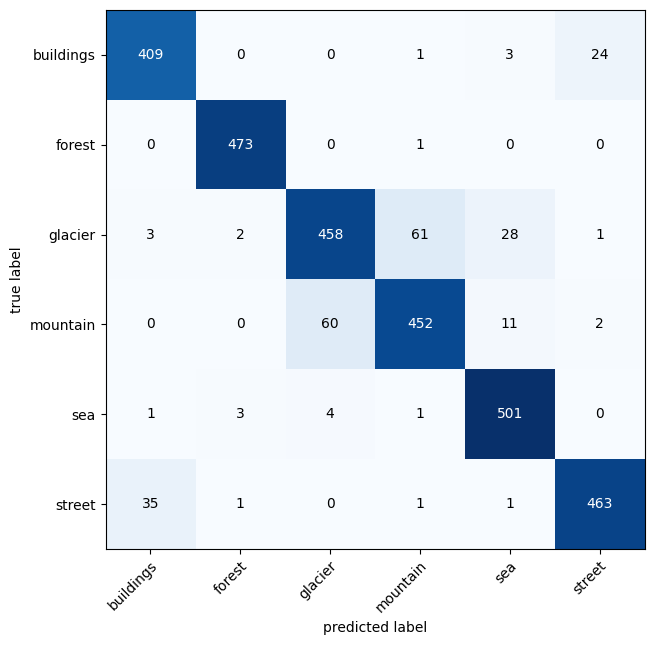

In [26]:
# Compute the confusion matrix using the true labels (y_test) and predicted labels (predictions)
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using the mlxtend library's plot_confusion_matrix function
plot_confusion_matrix(cm, figsize=(10,7), class_names=CLASS_NAMES)

# Display the plot
plt.show()


In [27]:
# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Specify the loss function for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007),  # Use the Adam optimizer with a specific learning rate
    metrics=["accuracy"]  # Track the accuracy metric during training
)

In [28]:
history_fine_tuning = model.fit(
    train_data,                               # Training data
    epochs=50,                               # Number of training epochs
    batch_size=32,                           # Batch size for each iteration
    validation_data=(test_data),              # Validation data
    callbacks=[tensorboarder, checkpointer, earlystopper],  # List of callbacks for training
    validation_steps=int(0.15*len(test_data)), # Number of validation steps
    use_multiprocessing=True,                 # Enable multiprocessing for faster data loading
    initial_epoch=history.epoch[-1]           # Initial epoch for resuming training
)


Epoch 9/50
439/439 [==============================] - 110s 222ms/step - loss: 0.2430 - accuracy: 0.9133 - val_loss: 0.2542 - val_accuracy: 0.9152
Epoch 10/50
439/439 [==============================] - 94s 213ms/step - loss: 0.2447 - accuracy: 0.9095 - val_loss: 0.2496 - val_accuracy: 0.9241
Epoch 11/50
439/439 [==============================] - 95s 216ms/step - loss: 0.2397 - accuracy: 0.9156 - val_loss: 0.2581 - val_accuracy: 0.9219
Epoch 12/50
439/439 [==============================] - 94s 213ms/step - loss: 0.2421 - accuracy: 0.9134 - val_loss: 0.2567 - val_accuracy: 0.9219
Epoch 13/50
439/439 [==============================] - 94s 213ms/step - loss: 0.2420 - accuracy: 0.9110 - val_loss: 0.2606 - val_accuracy: 0.9196


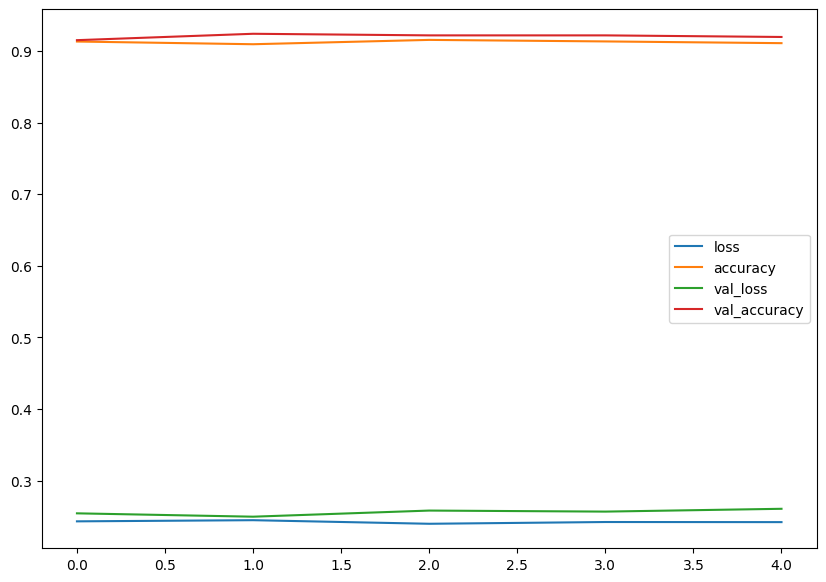

In [29]:
# Create a DataFrame from the history of fine-tuning
df_history = pd.DataFrame(history_fine_tuning.history)

# Plot the training and validation metrics
df_history.plot(figsize=(10, 7))

# Show the plot
plt.show()


In [30]:
# Evaluate the model on the test data
model.evaluate(test_data)

94/94 [==============================] - 10s 105ms/step - loss: 0.2240 - accuracy: 0.9183


[0.2240161895751953, 0.9183333516120911]

In [ ]:
# Make predictions using the trained model
predictions = model.predict(test_data)

# Convert predictions to class labels
predictions = tf.argmax(predictions, axis=1)

# Prepare the ground truth labels for evaluation
y_test = []

# Iterate over each sample in the test dataset
for _, label in tqdm(test_data.unbatch()):
    # Get the ground truth label and append it to the list
    y_test.append(tf.argmax(label))

# Convert the list of ground truth labels to a TensorFlow Variable
y_test = tf.Variable(y_test)


In [ ]:
# Calculate and print the accuracy score
print(accuracy_score(y_test, predictions))

In [ ]:
# Print classification report
print(classification_report(y_test, predictions))

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plot_confusion_matrix(cm, figsize=(10, 7), class_names=CLASS_NAMES)

# Show the plot
plt.show()


In [ ]:
test_data_shuffled = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,                              # Path to the directory containing test images
    batch_size=32,                          # Number of samples per batch
    image_size=IMG_SHAPE,                    # Desired size for the images
    shuffle=True,                           # Whether to shuffle the data
    label_mode="categorical",               # Mode for generating labels
    seed=42                                 # Seed for shuffling the data
)

In [ ]:
images = []
labels = []
x = 0

# Loop through the shuffled test_data
for i in test_data_shuffled.unbatch():
    # Check if we have reached 10 samples
    if (x == 10):
        break
    
    # Append image and label to respective lists
    images.append(i[0])
    labels.append(i[1])
    
    # Increment counter
    x += 1

# Create a new figure with a specified size
fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1

# Iterate over each image and label
for image, label in zip(images, labels):
    # Add a subplot to the figure at the current position
    fig.add_subplot(rows, cols, x)
    
    # Make a prediction using the model on the current image
    prediction = model.predict(tf.expand_dims(image, axis=0))
    prediction = CLASS_NAMES[tf.argmax(prediction.flatten())]
    label = CLASS_NAMES[tf.argmax(label)]
    
    # Set the title of the subplot to include the label and prediction
    plt.title(f"Label: {label}, Prediction: {prediction}")
    
    # Display the image, normalizing the pixel values between 0 and 1
    plt.imshow(image/255.)
    
    # Turn off axis labels
    plt.axis("off")
    
    # Increment the subplot counter
    x += 1
